In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
df = pd.read_csv('C:\\Users\\user\\Desktop\\uma\\train\\TRAIN_PREPARED.csv',parse_dates = ['cut_date','first_date','last_date'])
target = df.label

In [120]:
# only 25% of data has label 1,so this dataset is slightly Imbalanced 
df.label.value_counts()

0.0    133548
1.0     46701
Name: label, dtype: int64

In [3]:
d = df.last_date - df.first_date
d = d.dt.days
df.drop(columns=['cut_date','first_date','last_date','user','label'],inplace = True)
df['days'] = d

In [103]:
X_train, X_test, y_train, y_test = train_test_split(df, target, random_state=42,train_size =0.8)
#slightly fix Imbalanced dataest
from sklearn.utils import resample
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)
# separate minority and majority classes
not_fraud = X[X.label==0]
fraud = X[X.label==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results
upsampled = pd.concat([not_fraud, fraud_upsampled])
print(upsampled.label.value_counts())
y_train = upsampled.label
X_train = upsampled.drop('label', axis=1)

1.0    106890
0.0    106890
Name: label, dtype: int64


In [104]:
#feature selection
xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=20, 
                              random_state=42, eval_metric=["auc", "error", "error@0.6"])


xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-auc:0.660899	validation_0-error:0.392954	validation_0-error@0.6:0.260527
[1]	validation_0-auc:0.663641	validation_0-error:0.380499	validation_0-error@0.6:0.260527
[2]	validation_0-auc:0.664504	validation_0-error:0.388904	validation_0-error@0.6:0.260527
[3]	validation_0-auc:0.668513	validation_0-error:0.377559	validation_0-error@0.6:0.260499
[4]	validation_0-auc:0.670752	validation_0-error:0.379029	validation_0-error@0.6:0.254313
[5]	validation_0-auc:0.672382	validation_0-error:0.373176	validation_0-error@0.6:0.253537
[6]	validation_0-auc:0.673606	validation_0-error:0.374785	validation_0-error@0.6:0.253481
[7]	validation_0-auc:0.674573	validation_0-error:0.370874	validation_0-error@0.6:0.254757
[8]	validation_0-auc:0.675399	validation_0-error:0.370846	validation_0-error@0.6:0.255506
[9]	validation_0-auc:0.676549	validation_0-error:0.369237	validation_0-error@0.6:0.255839
[10]	validation_0-auc:0.678196	validation_0-error:0.366463	validation_0-error@0.6:0.255007
[11]	vali

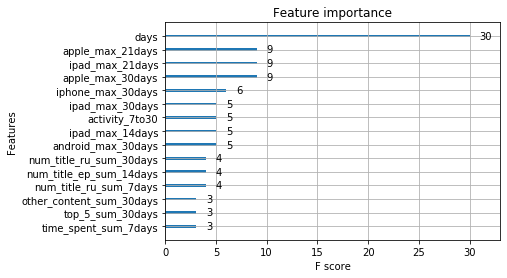

In [105]:
xgb.plot_importance(xgb_model, max_num_features=15)
plt.show()

In [106]:
selection = SelectFromModel(xgb_model , threshold=-np.inf, prefit=True,max_features= 11)
select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)



In [107]:
random_forest = RandomForestClassifier(n_estimators = 115)
random_forest.fit(select_X_train, y_train)
y_pred = random_forest.predict(select_X_test)

In [108]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
print("Accuracy:",accuracy_score(y_test, y_pred))
print("roc_auc_score:",roc_auc_score(y_test, y_pred))
print("f1_score:",f1_score(y_test, y_pred))

Accuracy: 0.8135367545076283
roc_auc_score: 0.7648245848128922
f1_score: 0.6494942121180519


In [110]:
df2 = pd.read_csv('C:\\Users\\user\\Desktop\\uma\\train\\TEST_PREPARED.csv',parse_dates = ['cut_date','first_date','last_date'])
user = df2.user

In [111]:
day = df2.last_date - df2.first_date
day = day.dt.days
df2.drop(columns=['cut_date','first_date','last_date','user'],inplace = True)
df2['days'] = day


In [112]:
select_pred = selection.transform(df2)

In [113]:
y_pred2 = random_forest.predict(select_pred)

In [114]:
a = pd.Series(y_pred2)
frame = { 'user': user, 'pred': a } 
  
result = pd.DataFrame(frame) 
  
result.head()

,user,pred
0,e98a93bfc7,0.0
1,d813ccb3f5,0.0
2,3d07a90a91,1.0
3,5791e966d8,1.0
4,d982336d49,0.0


In [121]:
result.to_csv(index=False,path_or_buf ='C:\\Users\\user\\Desktop\\uma\\train\\result.csv')